In [5]:
import tidy3d as td
import numpy as np
import tidy3d.web as web
import scipy.interpolate

# Effective refractive index calculation from tidy3d
def var_eps_eff(point, ref_point, sim, wavelength=1.55, inf=1000):
    """
    To calculate the vertical slab mode at 'point', we will create a 2D slice of the given simulation at
    'point' that extends in the yz plane infinitely, ensuring that it captures the entire permittivity
    profile. Then, to find the 1D mode profile, we use the Tidy3D ModeSolver on a plane at 'point' that
    extends infinitely in the xz plane. This intersection results in the ModeSolver operating on a line
    at 'point' that covers its entire z profile. We then use this to solve for n_eff and M in the above
    formula.
    """
    sim_2d_center = (point[0], point[1], 0) # given a 3D sim, we update the center to create our 2D slice
    sim_2d_size = (0, inf, inf) # we ensure the 2D span of the simulation in the yz plane captures everything
    
    # now we create the 2D simulation, keeping the structures and updating the boundary conditions
    sim_2d = sim.updated_copy(center=sim_2d_center,
                              size=sim_2d_size,
                              sources=[],
                              monitors=[],
                              boundary_spec=sim.boundary_spec.updated_copy(x=td.Boundary.periodic())
                             )
    
    # Now we solve for the mode at 'point':
    # We create the plane in xz that we'll use to examine the mode in z
    mode_solver_plane = td.Box(center=sim_2d.center, size=(td.inf, 0, td.inf))
    # Now we define the mode solver using this plane. We need only solve for one mode here, hence the ModeSpec
    mode_solver = td.plugins.mode.ModeSolver(simulation=sim_2d,
                                             plane=mode_solver_plane,
                                             mode_spec=td.ModeSpec(num_modes=1),
                                             freqs=[td.C_0/wavelength])
    
    # Note that here the mode solving is done locally. For users desiring more accuracy, the remote mode
    # solver should be used.
    mode_data = mode_solver.solve()
    
    # get n_eff from the solver
    n_eff = mode_data.n_eff.item()
    if point == ref_point: return n_eff**2 # if point is the reference point, the integral is 0

    # get z permittivity profile at reference point
    x_ref, y_ref = ref_point
    eps_ref = sim.epsilon(box=td.Box(center=(x_ref, y_ref, list(sim.center)[2]), size=(0,0,td.inf)))
    
    # get z permittivity profile at 'point'
    x, y = point
    eps = sim.epsilon(box=td.Box(center=(x, y, list(sim.center)[2]), size=(0,0,td.inf)))
    
    eps_dif = np.squeeze(eps.values) - np.squeeze(eps_ref.values)

    # get M at the same z coordinates as those of (eps - eps_ref) so we can integrate their product
    z_coords = eps_ref.z.values
    mode_profile = mode_data.Ex
    Mz2 = scipy.interpolate.interp1d(x=mode_profile.z.values, y=np.abs(np.squeeze(mode_profile.values))**2)
    m_values = Mz2(z_coords)

    # calculate integrals
    num, denom = np.trapz(y=eps_dif*m_values, x=z_coords), np.trapz(y=m_values, x=z_coords)
    return n_eff**2 + num/denom

2024-04-20 15:57:47.524 | WARNING  | gdsfactory.config:showwarning:296 - Port width mismatch: 0.4 != 0.55 in straight_length0p162_width0p4 on layer (1, 0)
2024-04-20 15:57:47.527 | WARNING  | gdsfactory.config:showwarning:296 - Port width mismatch: 0.5 != 0.55 in straight_length0p6_width0p5 on layer (1, 0)


/home/doan/miniconda3/envs/mp/lib/python3.11/site-packages/gdsfactory/component_reference.py:812: UserWarning: Port width mismatch: 0.4 != 0.55 in straight_length0p162_width0p4 on layer (1, 0)
  warnings.warn(message)
/home/doan/miniconda3/envs/mp/lib/python3.11/site-packages/gdsfactory/component_reference.py:812: UserWarning: Port width mismatch: 0.5 != 0.55 in straight_length0p6_width0p5 on layer (1, 0)
  warnings.warn(message)


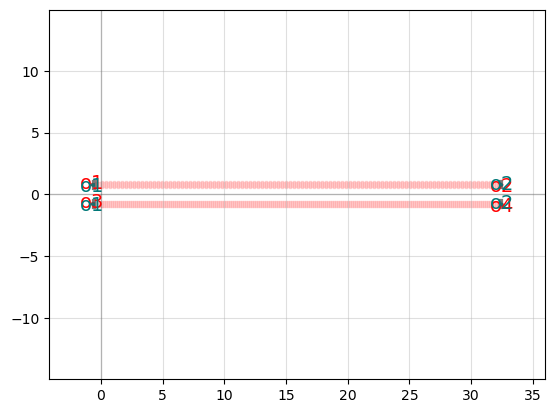

2024-04-20 15:57:47.666 | WARNING  | gdsfactory.config:showwarning:296 - Unnamed cells, 2 in 'dbr'
2024-04-20 15:57:47.668 | INFO     | gdsfactory.component:_write_library:2003 - Wrote to 'dbr.gds'
Cell names: dbr, Unnamed_b031560f, straight_length0p162_width0p4, straight_length0p162_width0p55, corr_dbr$8_offgrid, straight_length0p6_width0p5, DBR$5, straight_length0p162_width0p5, straight_transformed_81e33fe6, Unnamed_74bd60a0
[<gdstk.Cell object at 0x71985e674090>, <gdstk.Cell object at 0x71985e68e890>, <gdstk.Cell object at 0x71985e68e8b0>, <gdstk.Cell object at 0x71985e606f50>, <gdstk.Cell object at 0x71985e6057b0>, <gdstk.Cell object at 0x71985e607ef0>, <gdstk.Cell object at 0x71985e6078f0>, <gdstk.Cell object at 0x71985e4299d0>, <gdstk.Cell object at 0x71985e428dd0>, <gdstk.Cell object at 0x71985e428d90>]
Cell 'dbr' with 0 polygons, 0 flexpaths, 0 robustpaths, 2 references, and 0 labels


/tmp/ipykernel_25997/1160743115.py:84: UserWarning: Unnamed cells, 2 in 'dbr'
  c.write_gds("dbr.gds")


In [68]:
import gdsfactory as gf
import gdstk

def sys_dbr():
    def dbr_unit(w1, w2, l1, l2):
        c = gf.Component()
        r1 = c << gf.components.straight(length=l1, width=w1)
        r2 = c << gf.components.straight(length=l2, width=w2)
        r2.connect(port="o1", destination=r1.ports["o2"])
        c.add_port("o1", port=r1.ports["o1"])
        c.add_port("o2", port=r2.ports["o2"])
        return c

    unit_cell = dbr_unit(w1 = 0.55, w2 = 0.4, l1 = 0.162, l2 = 0.162)

    period = 100
    dbr = gf.Component("DBR")
    dbr.add_array(unit_cell, columns=period, rows=1, spacing=(0.162 + 0.162, 50))
    straight = gf.components.straight(width=0.5, length=0.6)
    p2 = dbr.add_port("o2", port=unit_cell.ports["o2"])
    p2.center = [(0.162 + 0.162)*period, 0]
    s = dbr << straight
    s.connect(port="o2", destination = unit_cell.ports["o1"])
    p1 = dbr.add_port("o1", port=s.ports["o1"])
    return dbr


def corr_dbr():
    def corr_dbr_unit(w1, w2, l1, l2, delta_w):
        c = gf.Component()
        r1 = c << gf.components.straight(length=l1, width=w1)
        # r2 = c << r1.copy()
        r2 = c << gf.components.straight(length=l2, width=w2)
        r2.move([l1, delta_w])
        c.add_port("o1", port=r1.ports["o1"])
        c.add_port("o2", port=r2.ports["o2"])
        return c

    un_cell = corr_dbr_unit(w1 = 0.5, w2 = 0.5, l1 = 0.162, l2 = 0.162, delta_w = -0.05)

    num_p = 100
    c_dbr = gf.Component("corr_dbr")
    c_dbr.add_array(un_cell, columns=num_p, rows=1, spacing=(0.162 + 0.162, 50))
    p2 = c_dbr.add_port("o2", port=un_cell.ports["o2"])
    p2.center = [(0.162 + 0.162)*num_p, -0.05]

    m_straight = gf.components.straight(width=0.025, length=0.162)
    r1 = c_dbr << m_straight
    r1.move([0, -0.5/2 - 0.025/2])

    straight = gf.components.straight(width=0.5, length=0.6)
    r2 = c_dbr << straight
    r2.move([-0.6, -0.025])

    c_dbr.add_port("o1", port=r2.ports["o1"])
    c_dbr = c_dbr.flatten_offgrid_references() # Avoiding grid snapping errors
    
    return c_dbr

wavelength0 = 1.532
freq0 = td.C_0 / wavelength0
fwidth = freq0 / 40.0
run_time = 5.0e-11
wavelength_min = td.C_0 / (freq0 + fwidth)

@gf.cell
def dbr() -> gf.Component:
    c = gf.Component("dbr")
    d1 = c << sys_dbr()
    d2 = c << corr_dbr()
    d1.move([0, wavelength0/2])
    d2.move([0, -wavelength0/2])
    c.add_port("o1", port=d1.ports["o1"])
    c.add_port("o2", port=d1.ports["o2"])
    c.add_port("o3", port=d2.ports["o1"])
    c.add_port("o4", port=d2.ports["o2"])
    return c

c = dbr()
gf.remove_from_cache(c)
c.plot()

# c = gf.components.ring_single()
c.write_gds("dbr.gds")

# # Load a GDSII library from the file we just created
lib_loaded = gdstk.read_gds("dbr.gds")

# Create a cell dictionary with all the cells in the file
all_cells = {c.name: c for c in lib_loaded.cells}

print("Cell names: " + ", ".join(all_cells.keys()))

print(lib_loaded.cells)

coup_cell_loaded = all_cells[c.name]

print(coup_cell_loaded)

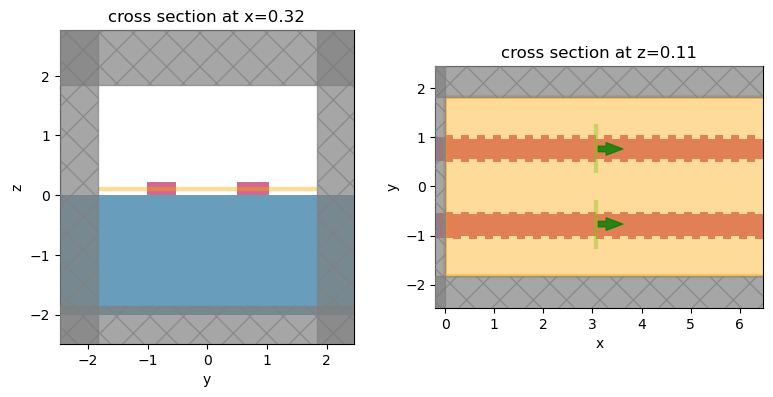

In [69]:
# basic imports
import numpy as np
import matplotlib.pylab as plt

# Tidy3D imports
import tidy3d as td

# materials
Air = td.Medium(permittivity=1.0)
Si = td.Medium(permittivity=3.47**2)
SiO2 = td.Medium(permittivity=1.44**2)

# substrate
sub_size = [td.inf, td.inf, 2]
sub_center = [0, 0, -1.0]
sub_medium = SiO2

# create the substrate
substrate = td.Structure(
    geometry=td.Box(center=sub_center, size=sub_size),
    medium=sub_medium,
    name="substrate",
)


t_wg = 0.22
tp = td.Geometry.from_gds(
    gds_cell=coup_cell_loaded,
    axis=2,
    slab_bounds=(0, t_wg),
    gds_layer=1,
)

# construct the taper structure using a PolySlab
dbr_structures = td.Structure(
    geometry=tp, medium=Si,
)


wg_length = 100 * 2*0.162
# full simulation domain
sim_size = Lx, Ly, Lz = [
    wg_length - wavelength0 * 1.5,
    2 * wavelength0 + 0.5 + 2 * 0.05,
    3.7,
]
sim_center = [Lx/2, 0, 0.0]

# boundary conditions - Bloch boundaries are used to emulate an infinitely long grating
boundary_spec = td.BoundarySpec(
    # x=td.Boundary.bloch(bloch_vec=num_periods/2),
    x=td.Boundary.pml(),
    y=td.Boundary.pml(),
    z=td.Boundary.pml(),
)

# grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20,wavelength=wavelength0)

# mode source for waveguide 1
source1_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth, amplitude=1)
mode_src1 = td.ModeSource(
    center=[2*wavelength0, wavelength0/2, t_wg / 2],
    size=[0, 0.5 * 2, t_wg * 2],
    mode_index=0,
    direction="+",
    source_time=source1_time,
    mode_spec=td.ModeSpec(num_modes=1, target_neff=3.47),
)

# mode source for waveguide 2
source2_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth, amplitude=1)
mode_src2 = td.ModeSource(
    center=[2*wavelength0, -wavelength0/2, t_wg / 2],
    size=[0, 0.5 * 2, t_wg * 2],
    mode_index=0,
    direction="+",
    source_time=source2_time,
    mode_spec=td.ModeSpec(num_modes=1, target_neff=3.47),
)

# create monitors
monitor_xy = td.FieldMonitor(
    center=[Lx/2, 0, t_wg / 2],
    size=[Lx, Ly, 0],
    freqs=[freq0],
    name="fields_xy",
)

freqs = np.linspace(freq0 - 2 * fwidth, freq0 + 2 * fwidth, 200)
ldas = np.linspace(1.46, 1.62, 101)
freqs = td.C_0 / ldas

monitor_flux_aligned = td.FluxMonitor(
    center=[Lx - 0.162*2, wavelength0/2, t_wg / 2],
    size=[0, 0.5 * 3, t_wg * 5],
    freqs=freqs,
    name="flux_aligned",
)

monitor_flux_misaligned = td.FluxMonitor(
    center=[Lx - 0.162*2, -wavelength0/2, t_wg / 2],
    size=[0, 0.5 * 3, t_wg * 5],
    freqs=freqs,
    name="flux_misaligned",
)

# list of all structures
structures = [substrate, dbr_structures]

# list of all sources
sources = [mode_src1, mode_src2]

# list of all monitors
monitors = [monitor_xy, monitor_flux_aligned, monitor_flux_misaligned]

# create the simulation
sim = td.Simulation(
    center=sim_center,
    size=sim_size,
    grid_spec=grid_spec,
    structures=structures,
    sources=sources,
    monitors=monitors,
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(
        boundary=td.PML()
    ),
    shutoff=0,
)

# plot the simulation domain
f, (ax1, ax3) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
sim.plot(x=0.162*2, ax=ax1)
sim.plot(z=t_wg / 2, ax=ax3)
ax3.set_xlim(-0.2, 20 * 0.162*2)
# ax3.set_xlim(80 * 0.162*2, 100 * 0.162*2)
plt.show()

Output()

15:58:45 CEST WARNING: Unable to fit with weighted RMS error under              
              'tolerance_rms' of 1e-05                                          

Output()

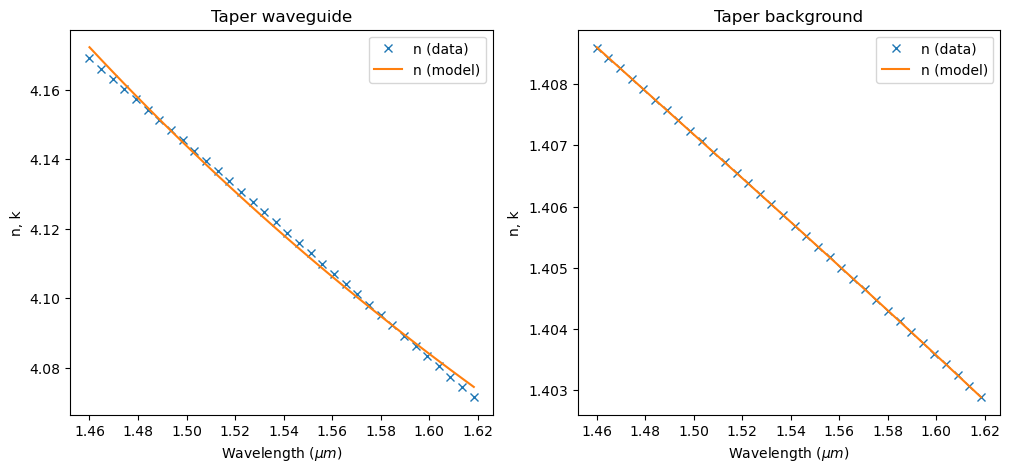

In [70]:
from tidy3d.plugins.dispersion import FastDispersionFitter
# This time we downsample at every third wavelength
step = 3
reference_point = (0,0)
waveguide_eps, background_eps = [], []
for wl in ldas[::step]: # calculate the variational effective permittivity at every third wavelength
    waveguide_eps.append(var_eps_eff((2,wavelength0/2), reference_point, sim, wavelength=wl))
    background_eps.append(var_eps_eff((2,0), reference_point, sim, wavelength=wl))


# again construct the materials fitting these calculated permittivities
waveguide_fitter = FastDispersionFitter(wvl_um=ldas[::step], n_data=np.sqrt(np.real(waveguide_eps)))
background_fitter = FastDispersionFitter(wvl_um=ldas[::step], n_data=np.sqrt(np.real(background_eps)))
waveguide_medium, rms_error = waveguide_fitter.fit()
background_medium, rms_error = background_fitter.fit()

# plot the material fits
fig, ax = plt.subplots(1, 2, figsize=(12,5))
waveguide_fitter.plot(waveguide_medium, ax=ax[0])
background_fitter.plot(background_medium, ax=ax[1])
ax[0].set_title("Taper waveguide")
ax[1].set_title("Taper background")
plt.show()

15:58:55 CEST WARNING: 'geometry=Box(type='Box', center=(0.0, 0.0, -1.0),       
              size=(inf, inf, 2.0)) name='substrate' type='Structure'           
              medium=PoleResidue(name=None, frequency_range=None,               
              allow_gain=False, nonlinear_spec=None, modulation_spec=None,      
              heat_spec=None, type='PoleResidue', eps_inf=1.0,                  
              poles=(((-3351656.8825255963-2767557371950351j),                  
              (43042338.21324172+1.7770668419047408e+16j)),))' (at              
              `simulation.structures[0]`) is completely outside of simulation   
              domain.                                                           

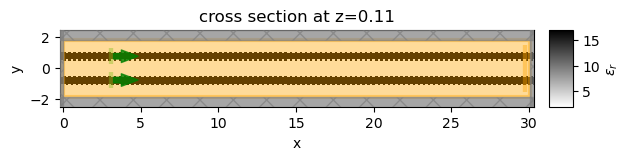

In [71]:
# in the same way as before, update the 3D simulation to a 2D simulation
new_structures = []
for structure in sim.structures:
    new_structures.append(structure.updated_copy(medium=waveguide_medium))

new_center = list(sim.center)
new_center[2] = t_wg / 2

new_size = list(sim.size)
new_size[2] = 0

# Update the symmetry to 2D
new_symmetry = list(sim.symmetry)
new_symmetry[2] = 0

sim2_2d = sim.updated_copy(
    center=new_center,
    size=new_size,
    structures=new_structures,
    boundary_spec=sim.boundary_spec.updated_copy(z=td.Boundary.periodic()),
    medium=background_medium,
    symmetry=new_symmetry,
)

sim2_2d.plot_eps(z=t_wg/2, freq=freq0)
plt.show()

In [ ]:
sim2_2d_data = web.run(sim2_2d, task_name="var eps bragg grating")